<a href="https://colab.research.google.com/github/darshan-analytics/CustomerChurnAnalysisUsingSparkETL-KaggleCompetition-/blob/main/CustomerChurnAnalysisUsingSparkETL(KaggleCompetition).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
while True:
  pass


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.1/spark-2.4.1-bin-hadoop2.7.tgz
!tar xf spark-2.4.1-bin-hadoop2.7.tgz
!pip install -q findspark

tar: spark-2.4.1-bin-hadoop2.7.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null


In [5]:
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz


In [6]:
!tar xf spark-3.0.1-bin-hadoop2.7.tgz


In [7]:
!pip install -q findspark


In [8]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [9]:
import findspark
findspark.init()

In [10]:
findspark.find()

'/content/spark-3.0.1-bin-hadoop2.7'

In [11]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Spark")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [43]:
spark

In [12]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')

--2021-02-18 19:47:56--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.213.190.117, 3.217.26.81, 52.54.16.202, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.213.190.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  18.9MB/s    in 0.7s    

2021-02-18 19:47:57 (18.9 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [13]:
!curl -s http://localhost:4040/api/tunnels


{"tunnels":[],"uri":"/api/tunnels"}


In [15]:
!unzip "/content/drive/MyDrive/customer-churn-prediction-2020.zip"


Archive:  /content/drive/MyDrive/customer-churn-prediction-2020.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [16]:
df = spark.read.csv("train.csv", header=True, inferSchema=True)


In [17]:
df.printSchema()

root
 |-- state: string (nullable = true)
 |-- account_length: integer (nullable = true)
 |-- area_code: string (nullable = true)
 |-- international_plan: string (nullable = true)
 |-- voice_mail_plan: string (nullable = true)
 |-- number_vmail_messages: integer (nullable = true)
 |-- total_day_minutes: double (nullable = true)
 |-- total_day_calls: integer (nullable = true)
 |-- total_day_charge: double (nullable = true)
 |-- total_eve_minutes: double (nullable = true)
 |-- total_eve_calls: integer (nullable = true)
 |-- total_eve_charge: double (nullable = true)
 |-- total_night_minutes: double (nullable = true)
 |-- total_night_calls: integer (nullable = true)
 |-- total_night_charge: double (nullable = true)
 |-- total_intl_minutes: double (nullable = true)
 |-- total_intl_calls: integer (nullable = true)
 |-- total_intl_charge: double (nullable = true)
 |-- number_customer_service_calls: integer (nullable = true)
 |-- churn: string (nullable = true)



In [18]:
df.show()

+-----+--------------+-------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+-----+
|state|account_length|    area_code|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls|churn|
+-----+--------------+-------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+--------

In [19]:
df.describe().show()

+-------+-----+------------------+-------------+------------------+---------------+---------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+-------------------+-----------------+------------------+------------------+-----------------+------------------+-----------------------------+-----+
|summary|state|    account_length|    area_code|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|  total_day_calls| total_day_charge| total_eve_minutes|   total_eve_calls|  total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes| total_intl_calls| total_intl_charge|number_customer_service_calls|churn|
+-------+-----+------------------+-------------+------------------+---------------+---------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+-------------------+-----------------+--------------

In [20]:
table_name = 'for_churn_analysis'

In [21]:
df.createOrReplaceTempView(table_name)

In [22]:
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql import functions as F
import time

In [23]:
df.groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|   no| 3652|
|  yes|  598|
+-----+-----+



In [52]:
df2 = spark.sql("select state, sum(yes) as Churned, sum(no) as Not_churned from (for_churn_analysis) t PIVOT (count(area_code) for churn in ('yes','no')) group by state order by Churned DESC;")

In [53]:
df2.show(5000, truncate= False)

+-----+-------+-----------+
|state|Churned|Not_churned|
+-----+-------+-----------+
|NJ   |26     |70         |
|TX   |19     |79         |
|MN   |19     |89         |
|WV   |19     |120        |
|MD   |19     |67         |
|WA   |18     |62         |
|NV   |17     |66         |
|MT   |17     |63         |
|ME   |16     |73         |
|NY   |16     |80         |
|OK   |16     |62         |
|MI   |15     |72         |
|MS   |15     |67         |
|OR   |15     |84         |
|CT   |15     |73         |
|KS   |15     |72         |
|SC   |14     |58         |
|MA   |14     |75         |
|AL   |13     |88         |
|IN   |13     |70         |
|DE   |13     |67         |
|OH   |12     |83         |
|TN   |12     |67         |
|ID   |12     |94         |
|KY   |12     |73         |
|UT   |12     |85         |
|SD   |11     |64         |
|AR   |11     |60         |
|CA   |10     |29         |
|WY   |10     |85         |
|VT   |10     |76         |
|NH   |10     |68         |
|NM   |10     |68   

In [50]:
df4 = spark.sql("select state, ROUND(Churned *100 / Not_churned, 1) as Churned_percentage from (select state, sum(yes) as Churned, sum(no) as Not_churned from (for_churn_analysis) t PIVOT (count(area_code) for churn in ('yes','no')) group by state) order by Churned_percentage DESC;")

In [51]:
df4.show(5000, truncate= False)

+-----+------------------+
|state|Churned_percentage|
+-----+------------------+
|NJ   |37.1              |
|CA   |34.5              |
|WA   |29.0              |
|MD   |28.4              |
|MT   |27.0              |
|NV   |25.8              |
|OK   |25.8              |
|SC   |24.1              |
|TX   |24.1              |
|MS   |22.4              |
|ME   |21.9              |
|MN   |21.3              |
|MI   |20.8              |
|KS   |20.8              |
|CT   |20.5              |
|NY   |20.0              |
|DE   |19.4              |
|MA   |18.7              |
|IN   |18.6              |
|AR   |18.3              |
|OR   |17.9              |
|TN   |17.9              |
|SD   |17.2              |
|KY   |16.4              |
|WV   |15.8              |
|AL   |14.8              |
|NM   |14.7              |
|NH   |14.7              |
|OH   |14.5              |
|MO   |14.3              |
|UT   |14.1              |
|PA   |13.6              |
|FL   |13.4              |
|VT   |13.2              |
|

In [47]:
df3 = spark.sql("select area_code, ROUND(Churned *100 / Not_churned, 1) as Churned_percentage from (select area_code, sum(yes) as Churned, sum(no) as Not_churned from (for_churn_analysis) t PIVOT (count(state) for churn in ('yes','no')) group by area_code) order by Churned_percentage DESC;")

In [54]:
df3.show(5000, truncate= False)

+-------------+------------------+
|area_code    |Churned_percentage|
+-------------+------------------+
|area_code_510|17.7              |
|area_code_408|16.3              |
|area_code_415|15.8              |
+-------------+------------------+



In [55]:
df5 = spark.sql("select international_plan, ROUND(Churned *100 / Not_churned, 1) as Churned_percentage from (select international_plan, sum(yes) as Churned, sum(no) as Not_churned from (for_churn_analysis) t PIVOT (count(area_code) for churn in ('yes','no')) group by international_plan) order by Churned_percentage DESC;")

In [56]:
df5.show(5000, truncate = True)

+------------------+------------------+
|international_plan|Churned_percentage|
+------------------+------------------+
|               yes|              72.9|
|                no|              12.6|
+------------------+------------------+



In [70]:
df6 = spark.sql("select voice_mail_plan, ROUND(Churned *100 / Not_churned, 1) as Churned_percentage from (select voice_mail_plan, sum(yes) as Churned, sum(no) as Not_churned from (for_churn_analysis) t PIVOT (count(area_code) for churn in ('yes','no')) group by voice_mail_plan) order by Churned_percentage DESC;")

In [71]:
df6.show()

+---------------+------------------+
|voice_mail_plan|Churned_percentage|
+---------------+------------------+
|             no|              19.7|
|            yes|               8.0|
+---------------+------------------+



In [73]:
df7 = spark.sql("select total_day_minutes from for_churn_analysis where churn=('yes');")

In [74]:
df7.show()

+-----------------+
|total_day_minutes|
+-----------------+
|            129.1|
|            332.9|
|             62.4|
|            249.6|
|            173.1|
|            198.4|
|            178.9|
|            300.3|
|             61.6|
|            157.9|
|            237.9|
|            203.4|
|            212.1|
|            251.8|
|            196.8|
|            282.5|
|             70.7|
|            187.5|
|            167.1|
|            337.4|
+-----------------+
only showing top 20 rows



In [75]:
df8 = spark.sql("select total_day_minutes from for_churn_analysis where churn=('no');")

In [76]:
df8.show()

+-----------------+
|total_day_minutes|
+-----------------+
|            161.6|
|            243.4|
|            299.4|
|            166.7|
|            218.2|
|            157.0|
|            184.5|
|            258.6|
|            187.7|
|            128.8|
|            156.6|
|            196.4|
|            189.7|
|            224.4|
|            155.1|
|            183.0|
|            110.4|
|             81.1|
|            213.0|
|            134.3|
+-----------------+
only showing top 20 rows



In [79]:
df10 = df7.toPandas()

In [81]:
df11 = df8.toPandas()

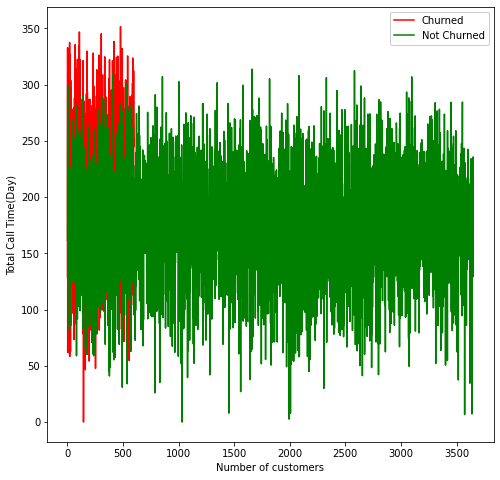

In [92]:
plt.figure(figsize=(8,8))
plt.plot(df10, label= 'Churned', color= 'red')
plt.plot(df11, label='Not Churned', color='green')
plt.legend(framealpha=1, frameon=True)
plt.xlabel('Number of customers')
plt.ylabel('Total Call Time(Day)')

plt.show()

In [93]:
dataset = df.toPandas()

In [94]:
dataset

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4245,MT,83,area_code_415,no,no,0,188.3,70,32.01,243.8,88,20.72,213.7,79,9.62,10.3,6,2.78,0,no
4246,WV,73,area_code_408,no,no,0,177.9,89,30.24,131.2,82,11.15,186.2,89,8.38,11.5,6,3.11,3,no
4247,NC,75,area_code_408,no,no,0,170.7,101,29.02,193.1,126,16.41,129.1,104,5.81,6.9,7,1.86,1,no
4248,HI,50,area_code_408,no,yes,40,235.7,127,40.07,223.0,126,18.96,297.5,116,13.39,9.9,5,2.67,2,no


In [95]:
dataset.isna().sum()

state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64

In [66]:
import matplotlib.pyplot as plt


DataFrame[voice_mail_plan: string, Churned_percentage: double]